<a href="https://colab.research.google.com/github/RaminParker/Huggingface_Text/blob/main/text_classification_with_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Wir starten mit Grundlagen zu Transformers. 

Anschließend verwenden wir sie um einen Text zu klassifizieren.

# Transformer Geschichte

Die Gescichte der Transformer begann 2017 durch ein Google Paper.

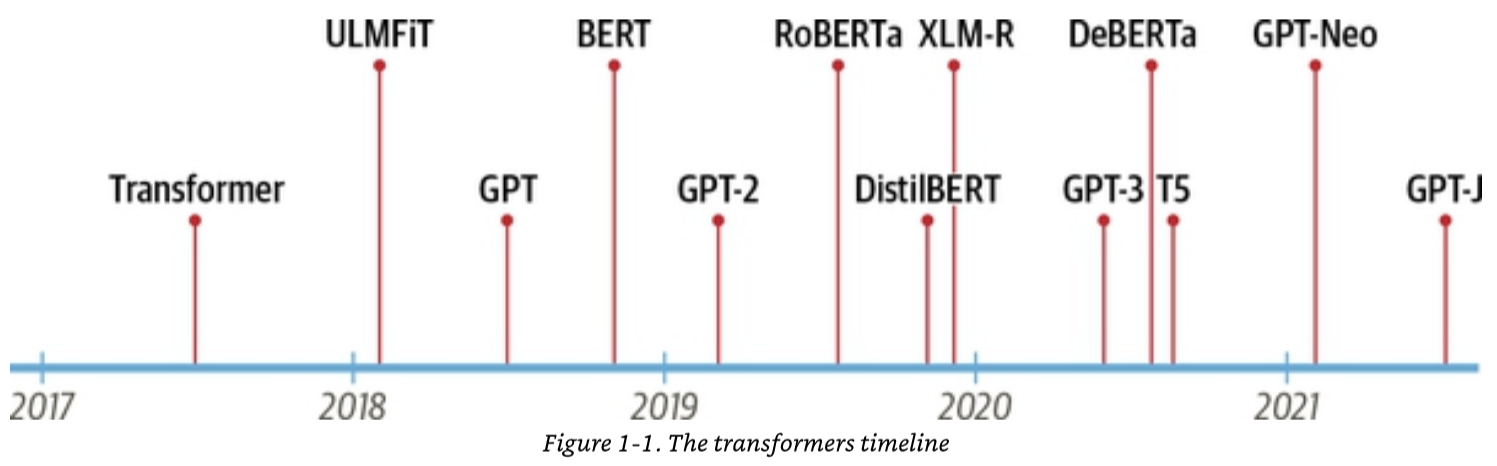

Basiert auf 3 Konzepte:


1.   Encoder-Decoder framework
2.   Attention mechanisms
3.   Transfer Learning



## Encoder-Decoder framework

Was ist RNN (Recurrent Neural Network)?


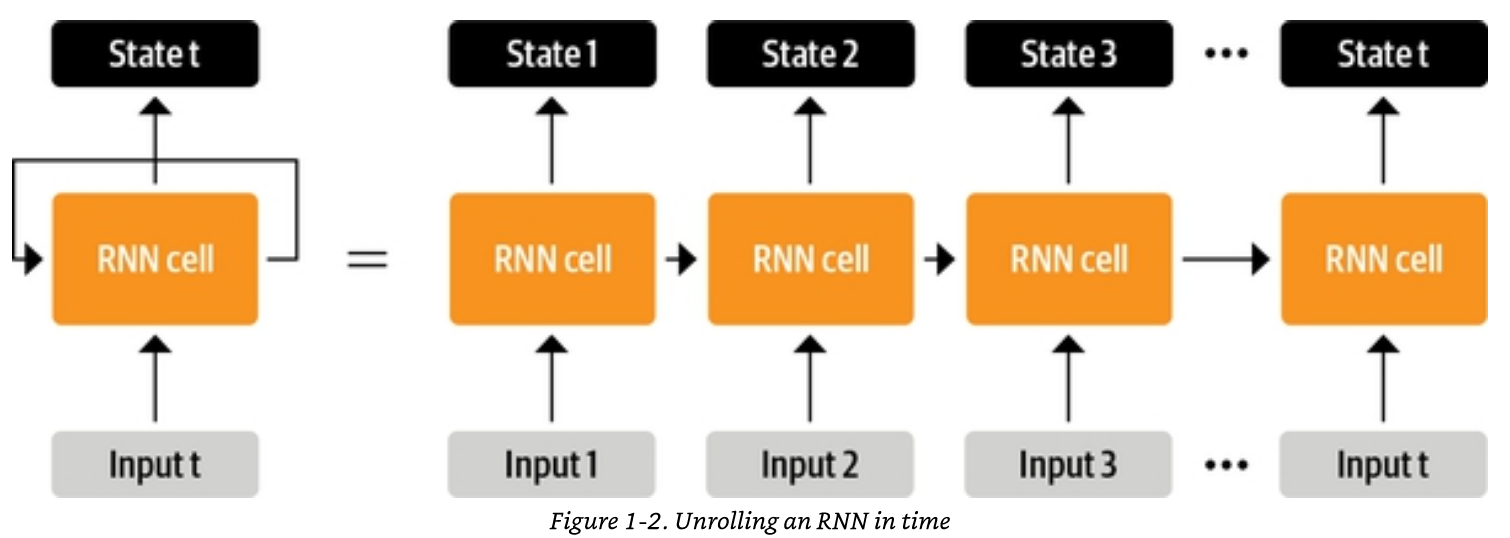

Eine verwendung von RNN ist die automatische Textübersetzung. Hierfür werden *encoder-decoder* oder *sequence-to-sequence* Architekturen verwendet.

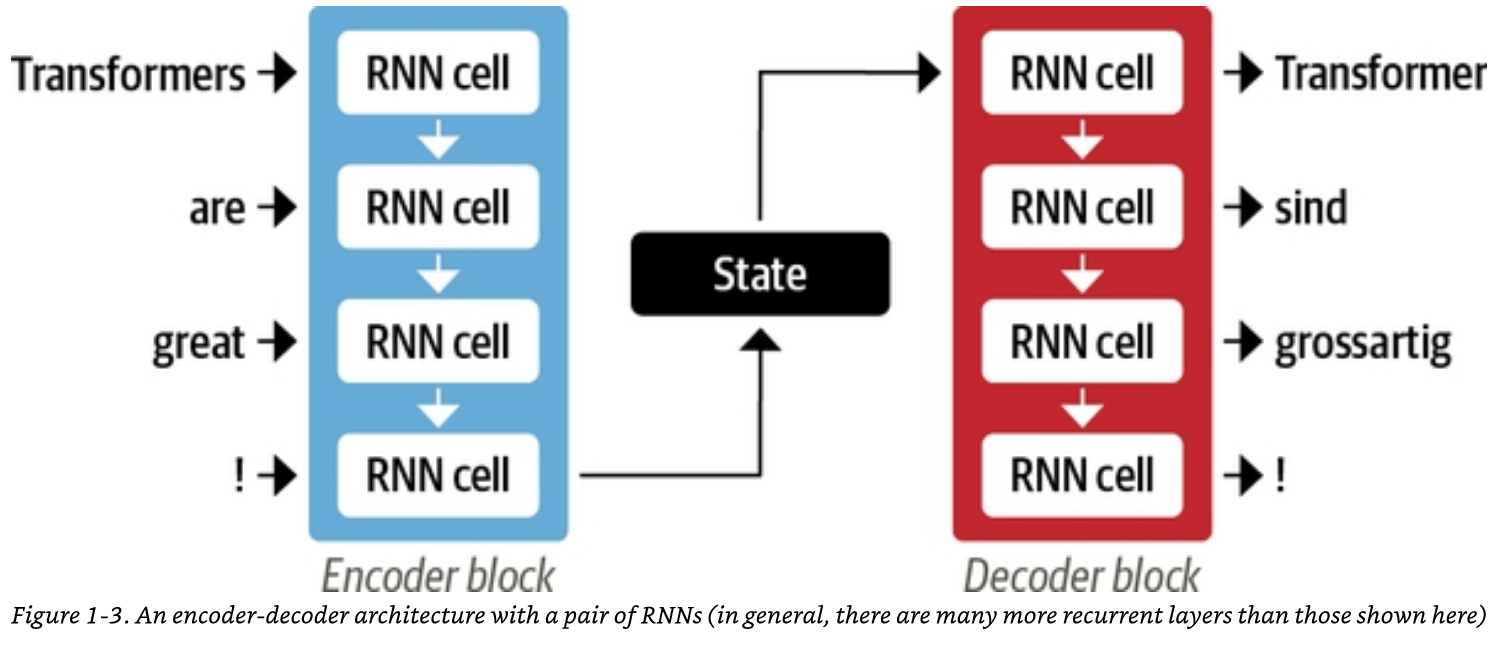

Der große Nachteil ist das alles in dem final hidden state encoded sein muss. Lange Input Sequenz und Bottelneck machen es vergesslich und langsam.

**Ausweg:** Dekoder bekommt Zugang zu allen hidden states des Encoders (attention).

## Attention Mechanisms

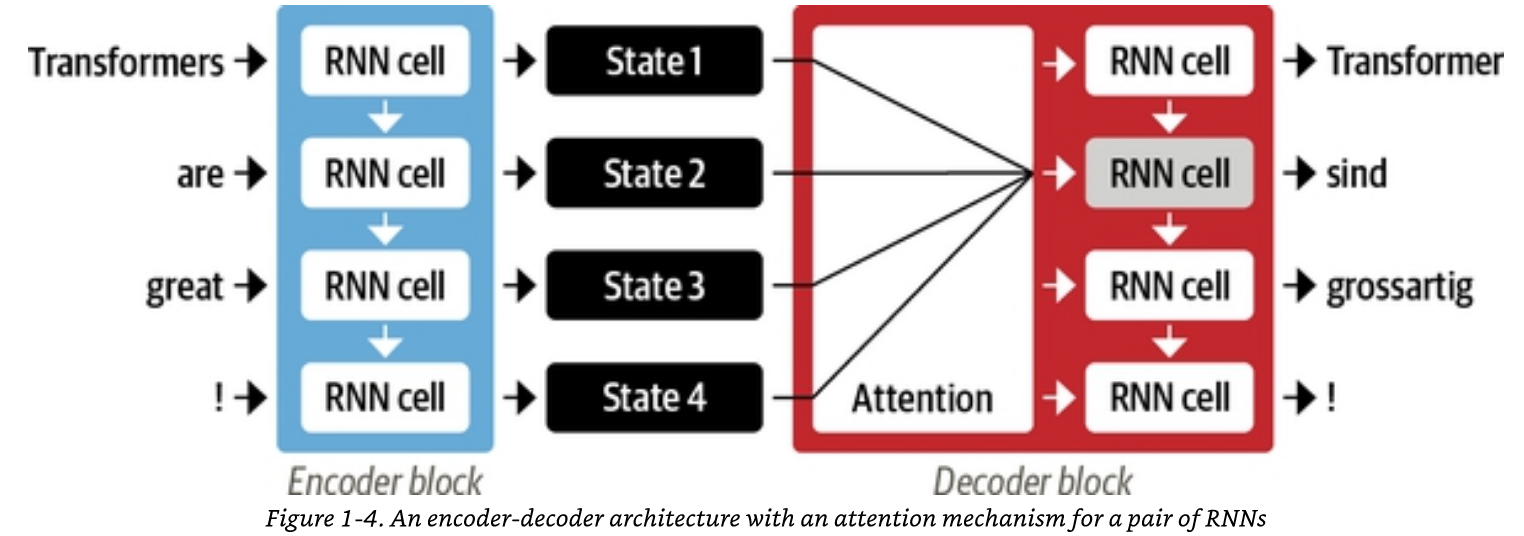

So geht es schneller, da es parallelisiert werden kann:

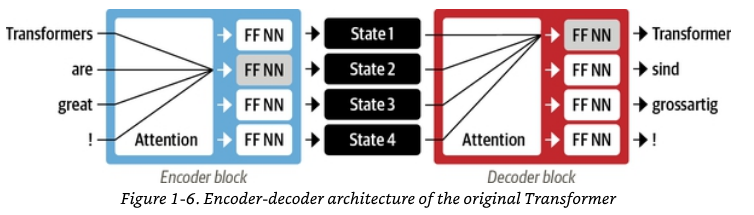

Guter Artikel: [A step-by-step guide to self-attention with illustrations and code](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

## Transfer Learning

Splitting des Models in *body* und *head*. Fine-Tune der Gewichte von *head*. 

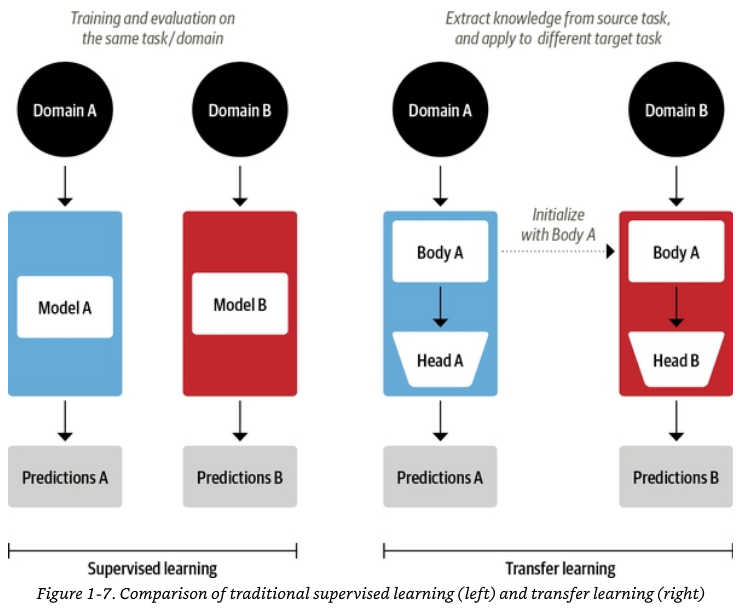

Verbindung von NLP mit Transfer Learning kam erst gegen 2017 / 18:

3 wesentliche Schritte:


1.   Pretraining: Vorhersage des nächsten Wortes. Nennt sich *language modeling*.
2.   Domain adaption: Nutzt ebenfalls language modeling, jedoch in Bezug auf ein anderes Target
3.   Fine-Tuning

GPT und BERT beruhen beide auf Self-Attention und Tranfer Learning. GPT nutzt insbesondere den Decoder-Teil der Transformer-Architektur. Bert nutzt den Encoder-Teil der Transformer-Architektur. 

Um die Nutzerfreundlichkeit der unzähligen Architekturen zu erhöhen hat [Huggingface](https://huggingface.co/) eine einheitliche Schnittstelle geschaffen um unterschiedlichste Transformer zu nutzen.

Mögliche Anwendungen (teilweise out-of-the-box):
- Textklassifizierung
- NER
- Question-Answering
- Zusammenfassungen
- Übersetzung
- Text-Generation

Die libraries enthalten den Code und Huggingface Hub enthält zahlreiche pretrained model weights, Datensätzte und Evaluation Metriken, Tokenizer und sehr viel mehr!!!




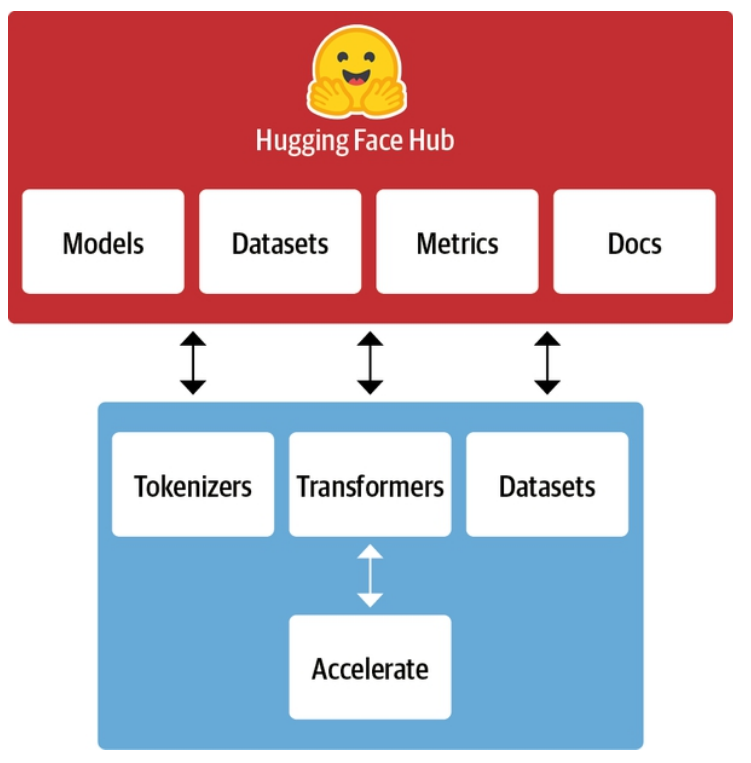



In [1]:
# from utils import *
# setup_chapter()

In [2]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter2=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 515, done.
remote: Counting objects: 100% (515/515), done.
remote: Compressing objects: 100% (278/278), done.
remote: Total 515 (delta 245), reused 479 (delta 231), pack-reused 0
Receiving objects: 100% (515/515), 29.39 MiB | 15.25 MiB/s, done.
Resolving deltas: 100% (245/245), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


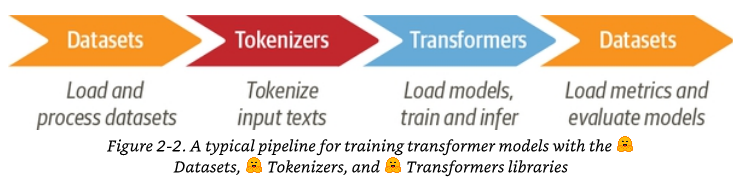

- Wir werden DistilBERT nutzen -> Ähnliche Performance wie BERT, aber deutlich performanter
- Ein Wechsel des Models ist leicht möglich

# Text Classification

## The Dataset

- Unser Datensatz könnte theoretisch alles sein, z.B. die Email-Kategorien in der Datenbank

### Grundlagen: Hugging Face Datasets

Wir nutzten einen Datensatz von [Hugging Face Hub](https://huggingface.co/datasets).

In [3]:
from datasets import list_datasets

all_datasets = list_datasets()

print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 22042 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']



Wir sehen, jeder Datensatz hat einen Namen.
Wir können jetzt einfach einen Datensatz auswählen.

In [4]:
# hide_output
from datasets import load_dataset

# emotions = load_dataset("emotion")
emotions = load_dataset("SetFit/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Ein Blick in das `emotions` object:

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

Wir bei einem dict können wir gezielt auf die einzelnen keys zugreifen.
Wir erhalten eine Instance der `Dataset` class.

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 16000
})

`train_ds` verhält sich wie ein Python array. 

Streng genommen ist es aber Apache Arrow, was sehr viel performanter ist.

In [7]:
len(train_ds)

16000

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [9]:
train_ds.column_names

['text', 'label', 'label_text']

Das sind die Features unseres Datensatzes:

In [10]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'label_text': Value(dtype='string', id=None)}


- `text` Spalte ist `string`  
- `label` Spalte ist ein `ClassLabel` object

In [11]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3], 'label_text': ['sadness', 'sadness', 'anger', 'love', 'anger']}


In [12]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


**Ganz wichtig!!!**

Im Beispiel haben wir den Datensatz aus HuggingFace Hub genommen. Wir können aber auch z.B. eine csv-Datei mittels `load_dataset` Funktion in das entsprechende Format laden! 


-  `load_dataset("csv", data_files="my_file.csv")` 

- `load_dataset("text", data_files="my_file.txt")` 

- `load_dataset("json", data_files="my_file.jsonl")`

### Von Datasets zu DataFrames

Umwandlung in ein DataFrame. Wechsel zurück jeder Zeit möglich. 

In [13]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Erstellung einer zusätzlichen Spalte für die Label-Namen mittels `int2str()`.

In [14]:
# def label_int2str(row):
#     return emotions["train"].features["label"].int2str(row)

# df["label_name"] = df["label"].apply(label_int2str)
# df.head()

### Wie sieht der Datensatz aus?

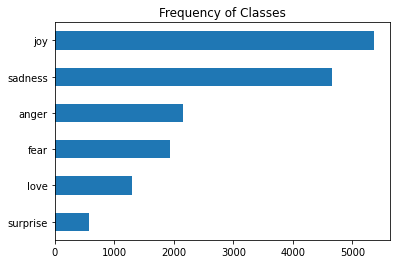

In [15]:
import matplotlib.pyplot as plt

df["label_text"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Um das Beispiel überscihtlich zu halten, belassen wir es mit weiteren Verfahren für imbalanced data.

### Wie lang sind die Tweets?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


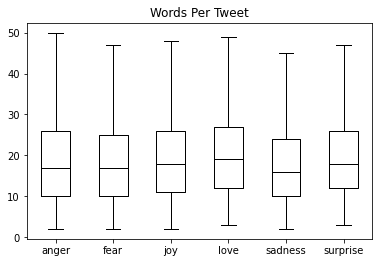

In [16]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_text", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Aus der Grafik sehen wir, dass die meisten Tweets für jede Emotion etwa 15 Wörter lang sind und die längsten Tweets deutlich unter der maximalen Kontextgröße von DistilBERT liegen. Texte, die länger als die Kontextgröße eines Modells sind, müssen gekürzt werden, was zu einem Leistungsverlust führen kann, wenn der gekürzte Text wichtige Informationen enthält. In diesem Fall scheint das kein Problem zu sein.

Jetzt benötigen wir kein DataFrame Format mehr:

In [17]:
emotions.reset_format()

## Umwandlung von Text in Tokens

Transformer models  wie DistilBERT können keine strings als Eingabe erhalten, sondern gehen davon aus, dass der Text tokenisiert und als **numerische Vektoren** codiert wurde. Die Tokenisierung ist der Schritt, den Text in die von dem Modell verwendeten atomaren Einheiten aufzuteilen. 

Es gibt mehrere **Tokenisierungsstrategien**, die man verwenden kann, und die optimale Aufteilung von Wörtern in Unterteilungen wird in der Regel aus dem Korpus gelernt. 2 Extrem-Beispiel sind character and word tokenization.

### Tokenisierungsstrategie: Character Tokenization

In [18]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


Ein ML-Model erwartet Nummern und keine Buchstaben -> _numericalization_

Wir geben jedem Token einen einzigartige Nummer.

In [19]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


Damit haben wir ein Mapping. Wir können jetzt die Tokens in integers umwandeln:

In [20]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Für jeden der insgesamt 38 input tokens haben wir jetzt einen one-hot vector mit 20 Dimensionen (da es 20 einzigartige Vokabeln gab)

In [21]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [22]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Nachteile:
- Wir verlieren die "Wörter". Diese müssen neu erlernt werden.

### Tokenisierungsstrategie: Word Tokenization

Anstatt Text in Buchstaben zu splitten, wird Text in Wörter gespittet.

Whitespace tokenization

In [23]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


Wir sehen, dass die Zeichensetznug nicht berücksichtigt wird -> `NLP.`

Das kann dazu führen, dass unser Vokabelsatz massiv ansteigt.

> Notiz: Einige word tokenizer haben spezielle Regeln für Zeichensetzung. Auch könnte man stemming oder lemmatization anwenden, welches die Wörter auf ihren Stam normalisert: (e.g., "great", "greater", and "greatest" all become "great"). Dadurch verlieren wir jedoch Informationen.

Um die Anzahl der Wörter zu begrenzen gibt es Tricks: Words that are not part of the vocabulary are classified as "unknown" and mapped to a shared `UNK` token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with `UNK`.

Wouldn't it be nice if there was a compromise between character and word tokenization that preserved all the input information _and_ some of the input structure? There is: _subword tokenization_.

### Tokenisierungsstrategie: Subword Tokenization

Das beste aus chracter und word tokenization. Weniger Information geht verloren, allerdings versucht es auch die Größe der Inputs gering zu halten. Subword tokenization wird *gelernt* von einem vortranierten Corpus und benutzt einen Mix aus statistischen Regeln und Algorithmen.

Es gibt viele subword tokenization Algorithmen. Einer davon ist WordPiece.


Die  `from_pretrained()` Methode benötigt nur die ID des Models aus dem Hub.

Hier wird der Tokenizer für DistilBERT geladen:

In [24]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Alternativ könnten wir auch direkt auf den Tokenizer zugreifen.

```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

Anwendung des WordPiece Toeknizer:

Wörter werden erneut in unique integers gemapped. Was die `attention_mask` bedeutet, schauen wir später an.

In [25]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Konvert `input_ids` zurück in Tokens:

In [26]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


-  `[CLS]` und `[SEP]` kennzeichnen Anfang und Ende des Satzes
- Alle Wörter sind in Kleinschreibung
- "tokenizing" und "NLP" wurden in jeweils 2 Wörter gesplittet, weil sie keine gewöhnlichen Wörter sind

Der Satz kann auch wieder hergestellt werden:

In [27]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


Anzahl der Vokabeln:

In [28]:
tokenizer.vocab_size

30522

Parameter des Tokenizers:

In [29]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

> warning: Bei der Verwendung von vortrainierten Modellen ist es wirklich wichtig, sicherzustellen, dass man den gleichen Tokenizer verwendet, mit dem das Modell trainiert wurde. Aus der Sicht des Modells ist das Wechseln des Tokenizers wie das Durcheinanderbringen des Wortschatzes. Wenn plötzlich alle um dich herum anfangen, zufällige Wörter wie "Haus" gegen "Katze" auszutauschen, wäre es auch für dich schwer zu verstehen, was los ist!

### Tokenizing des gesamten Datensatzten



Wir definieren folgende Funktion zur Tokenisierung unserer Daten:

- `padding=True` fügt den Beispielen Nullen hinzu, um sie auf die Länge des längsten Beispiels in einem Batch anzupassen
- `truncation=True` kürzt die Beispiele auf die maximale Kontextgröße des Modells.

In [30]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Anwendung:

In [31]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In unserem Beispiel finden wir einige der speziellen Tokens wieder:

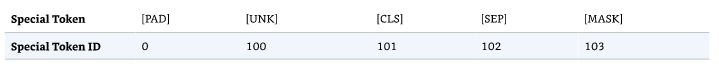

Des Weiter erhalten wir eine Liste `attention_mask`. Die hilft dem Model sich auf das wesentliche zu fokusieren und die "attentions" NICHT auf die paddings zu haben:

<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/> 

Anwendung der Tokenizing-Funktion auf den gesamten Datensatz:
- durch `batch = True` werden die Tweets in batches encoded
- durch `batch_size = None` wird Funktion tokenizing-Funktion wird angewendet auf den gesamten Datensatz als ein Batch 

In [32]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Anschließend haben wir weitere Spalten an unserem Datensatz:

In [33]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'label_text', 'input_ids', 'attention_mask']


## Training a Text Classifier

Um den Text zu klassifizieren, müssen wir das Model (DistilBert) noch anpassen.

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

- Zuerst wird der Text tokenisiert und als One-Hot-Vektoren dargestellt (token encodings). 
- Die Größe des Tokenizers bestimmt die Dimension der Token-Codierungen und besteht normalerweise aus 20.000 bis 200.000 eindeutigen Tokens. 
- Anschließend werden diese Token-Codierungen in Token-Embeddings konvertiert, die Vektoren in einem niedrigeren-dimensionalen Raum darstellen. 
- Durch den Encoder ensteht für jeden Token Embeding  ein Hidden State
- Hidden State läuft durch einen Classification head welches welches (im Falle von DistilBert) das maskierte Word vorhersagt.

Wir haben zwei Optionen, um ein solches Modell auf unserem Twitter-Datensatz zu trainieren:

- **Feature extraction:** Wir verwenden die Hidden States als Merkmale und trainieren nur einen Klassifikator darauf, ohne das vortrainierte Modell zu ändern.
- **Fine-tuning:** Wir trainieren das gesamte Modell end-to-end, wodurch auch die Parameter des vortrainierten Modells aktualisiert werden.


In den folgenden Abschnitten untersuchen wir beide Optionen für DistilBERT und untersuchen ihre Kompromisse.

### Transformers als Feature Extractors

In diesem Ansatz (Transformer als Feature Extractors) frieren wir das DistilBert Model ein und nehmen dessen Gewichte als Feature für einen beliebigen Klassifier.

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### Using pretrained models

Über huggingface können wir mittels der Klasse `AutoModel` bzw. die Methode  `from_pretrained()` an die Gewichte eines vortrainierten Models.

Hier laden wir DistilBERT checkpoints:

In [34]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

#### Extracting the last hidden states

Den `tokenizer` haben wir weiter oben bereits für unser Model "distilbert-base-uncased" definiert.

Beispiel: Extraktion des letzten hidden state:

In [35]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


- Die shape des Tensors ist `[batch_size, n_tokens]`. 


Nachdem wir die Encodings nun als Tensor haben, wollen wir diese auf das selbe device wie das Model bekommen und sie mit dem Model "verschmelzen". 

In [36]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


- Mittels `torch.no_grad()` verhindern wir die automatische berechnung von Gradienten. 
- Abhängig von den Model Konfigurationen, kann der Output verschiedene Objekte enthalten: 
  - hidden states
  - losses
  - attentions

Das aktuelle Model gibt lediglich die die hidden states aus.

In [37]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

- shape `[batch_size, n_tokens, hidden_dim]`. 
- Jedes der 6 input tokens hat einen 768-dimensionalen Vektor bekommen.

For classification tasks, it is common practice to just use the hidden state associated with the `[CLS]` token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into `outputs.last_hidden_state` as follows:

In [38]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Die selbe Logik die wir gerade auf einen String anwendeten, können wir auch auf den gesamten Datensatz anwenden.

In [39]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

Der einzige Unterschied zwischen dieser Funktion und unserer vorherigen Logik besteht in dem letzten Schritt, in dem wir den finalen hidden state als NumPy-Array zurück auf die CPU legen.

Da unser Modell Tensoren als Eingabe erwartet, müssen wir als nächstes die Spalten ``input_ids`` und ``attention_mask`` in das Format ``torch`` konvertieren, wie folgt:

In [40]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

Anwendung auf den gesamten Datensatz:

In [41]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Die default batch size ist `batch_size=1000`.

Nach der Anwendung von ``extract_hidden_states()`` haben wir nun eine neue ``hidden_state`` Spalte in unserem Datensatz:

In [42]:
emotions_hidden["train"].column_names

['text', 'label', 'label_text', 'input_ids', 'attention_mask', 'hidden_state']

Jetzt, da wir die hidden states mit jedem Tweet verknüpft haben, ist der nächste Schritt, einen Klassifizierer darauf zu trainieren. 

#### Creating a feature matrix

Wir nutzten die hidden states als input features und die Labels als target.

In [43]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Im nächsten Schritt werden wir die features visualisieren.

#### Visualizing the training set

Mittels UMAP reduzieren wir die 768 Dimensionen auf 2:

In [44]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.430415,6.903274,0
1,-3.012873,6.127706,0
2,5.441454,3.247171,3
3,-2.156244,3.923883,2
4,-3.250038,4.163298,3


Plot:

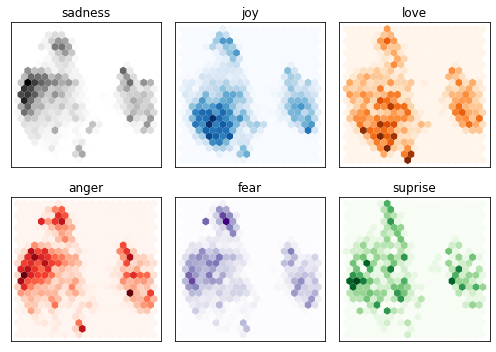

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
#labels = emotions["train"].features["label"].names
labels = ["sadness" , "joy" ,"love", "anger", "fear", "suprise"]

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

Aus diesem Diagramm können wir einige klare Muster erkennen: 
- Die negativen Gefühle wie `sadness`, `anger`, und `fear` besetzen alle ähnliche Bereiche mit leicht unterschiedlichen Verteilungen. 
- Auf der anderen Seite sind `joy` and `love` gut von den negativen Emotionen getrennt und teilen auch einen ähnlichen Raum. 
-  `surprise` ist überall verstreut.

#### Training a simple classifier


We've seen that the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Scikit-Learn. Training such a simple model is fast and does not require a GPU:

In [60]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [61]:
lr_clf.score(X_valid, y_valid)

0.633

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a `DummyClassifier` that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [62]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

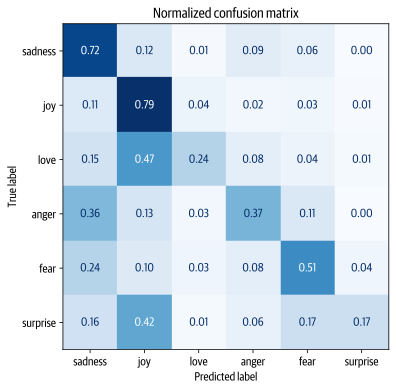

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that `anger` and `fear` are most often confused with `sadness`, which agrees with the observation we made when visualizing the embeddings. Also, `love` and `surprise` are frequently mistaken for `joy`.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

### Fine-Tuning Transformers


Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them as shown in <<encoder-tuning>>. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the `Trainer` API from image:images/logo.png[hf,13,13] Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [ ]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

#### Training the model

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:

```bash
$ huggingface-cli login
```

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`: 

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.840900,0.327445,0.896500,0.892285
2,0.255000,0.220472,0.922500,0.922550


Looking at the logs, we can see that our model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:

In [ ]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [ ]:
preds_output.metrics

{'test_loss': 0.22047173976898193,
 'test_accuracy': 0.9225,
 'test_f1': 0.9225500751072866,
 'test_runtime': 1.6357,
 'test_samples_per_second': 1222.725,
 'test_steps_per_second': 19.564}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix again:

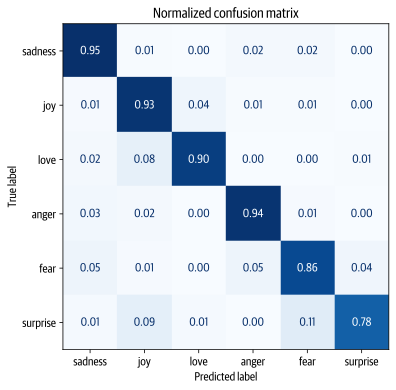

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

### Sidebar: Fine-Tuning with Keras

If you are using TensorFlow, it's also possible to fine-tune your models using the Keras API. The main difference from the PyTorch API is that there is no `Trainer` class, since Keras models already provide a built-in `fit()` method. To see how this works, let's first load  DistilBERT as a TensorFlow model:

In [ ]:
#hide_output
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels))

2021-10-29 15:33:36.938811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-10-29 15:33:36.938844: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-29 15:33:36.939933: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-29 15:33:36.962642: W tens

Next, we'll convert our datasets into the `tf.data.Dataset` format. Since we have already padded our tokenized inputs, we can do this easily by applying the `to_tf_dataset()` method to `emotions_encoded`:

In [ ]:
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=True,
    batch_size=batch_size)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
    columns=tokenizer_columns, label_cols=["label"], shuffle=False,
    batch_size=batch_size)

Here we've also shuffled the training set, and defined the batch size for it and the validation set. The last thing to do is compile and train the model:

In [ ]:
#hide_output
import tensorflow as tf

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

2021-10-29 15:36:00.548707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
250/250 [==============================] - 478s 2s/step - loss: 0.5379 - sparse_categorical_accuracy: 0.8138 - val_loss: 0.1452 - val_sparse_categorical_accuracy: 0.9430
Epoch 2/2
250/250 [==============================] - 471s 2s/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.1512 - val_sparse_categorical_accuracy: 0.9335


### End sidebar

#### Error analysis

Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

Using the `map()` method once more, we can apply this function to get the losses for all the samples:

In [ ]:
#hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

Finally, we create a `DataFrame` with the texts, losses, and predicted/true labels:

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

We can now easily sort `emotions_encoded` by the losses in either ascending or descending order. The goal of this exercise is to detect one of the following:

- _Wrong labels_:: Every process that adds labels to data can be flawed. Annotators can make mistakes or disagree, while labels that are inferred from other features can be wrong. If it was easy to automatically annotate data, then we would not need a model to do it. Thus, it is normal that there are some wrongly labeled examples. With this approach, we can quickly find and correct them.

- _Quirks of the dataset_:: Datasets in the real world are always a bit messy. When working with text, special characters or strings in the inputs can have a big impact on the model's predictions. Inspecting the model's weakest predictions can help identify such features, and cleaning the data or injecting similar examples can make the model more robust.

Let's first have a look at the data samples with the highest losses:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.704531
1963,i called myself pro life and voted for perry w...,joy,sadness,5.484461
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.434768
882,i feel badly about reneging on my commitment t...,love,sadness,5.257482
1950,i as representative of everything thats wrong ...,surprise,sadness,4.827708
1509,i guess this is a memoir so it feels like that...,joy,fear,4.713047
1274,i am going to several holiday parties and i ca...,joy,sadness,4.704955
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.656096
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.593202
1111,im lazy my characters fall into categories of ...,joy,fear,4.311287


We can clearly see that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples with no clear class, which might be either mislabeled or require a new class altogether. In particular, `joy` seems to be mislabeled several times. With this information we can refine the dataset, which often can lead to as big a performance gain (or more) as having more data or larger models!

When looking at the samples with the lowest losses, we observe that the model seems to be most confident when predicting the `sadness` class. Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investing time into looking at the examples that the model is most confident about, so that we can be confident that the model does not improperly exploit certain features of the text. So, let's also look at the predictions with the smallest loss:

In [ ]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017331
244,im kinda relieve but at the same time i feel d...,sadness,sadness,0.017392
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017400
392,i remember feeling disheartened one day when w...,sadness,sadness,0.017461
1310,i feel like an ungrateful asshole,sadness,sadness,0.017485
189,i leave the meeting feeling more than a little...,sadness,sadness,0.017670
1120,i am feeling a little disheartened,sadness,sadness,0.017685
783,i feel like i deserve to be broke with how fri...,sadness,sadness,0.017888
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017899
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.017913


We now know that the `joy` is sometimes mislabeled and that the model is most confident about predicting the label `sadness`. With this information we can make targeted improvements to our dataset, and also keep an eye on the class the model seems to be very confident about. 

The last step before serving the trained model is to save it for later usage. image:images/logo.png[hf,13,13] Transformers allows us to do this in a few steps, which we'll show you in the next section.

#### Saving and sharing the model


The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any community-generated model can be downloaded from the Hub just like we downloaded the DistilBERT model. With the `Trainer` API, saving and sharing a model is simple:

In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/lewtun/distilbert-base-uncased-finetuned-emotion/commit/352c4147e4754f73a0b41f7b175f4a907270c9c9'

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline:

In [ ]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

Then let's test the pipeline with a sample tweet:

In [ ]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

Finally, we can plot the probability for each class in a bar plot. Clearly, the model estimates that the most likely class is `joy`, which appears to be reasonable given the tweet:

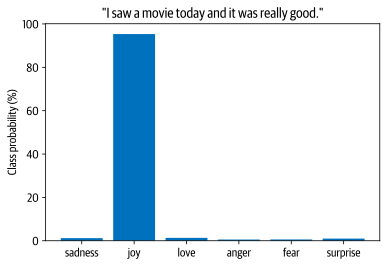

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## Conclusion

Congratulations, you now know how to train a transformer model to classify the emotions in tweets! We have seen two complementary approaches based on features and fine-tuning, and investigated their strengths and weaknesses. 

However, this is just the first step in building a real-world application with transformer models, and we have a lot more ground to cover. Here's a list of challenges you're likely to experience in your NLP journey:

My boss wants my model in production yesterday!::
In most applications, your model doesn't just sit somewhere gathering dust - you want to make sure it's serving predictions! When a model is pushed to the Hub, an inference endpoint is automatically created that can be called with HTTP requests. We recommend checking out the [documentation](https://api-inference.huggingface.co/docs/python/html/index.html) of the Inference API if you want to learn more. 

My users want faster predictions!::
We've already seen one approach to this problem: using DistilBERT. In <<chapter_compression>> we'll dive into knowledge distillation (the process by which DistilBERT was created), along with other tricks to speed up your transformer models.


Can your model also do X?::
As we've alluded to in this chapter, transformers are extremely versatile. In the rest of the book we will be exploring a range of tasks, like question answering and named entity recognition, all using the same basic architecture.

None of my texts are in English!::
It turns out that transformers also come in a multilingual variety, and we'll use them in <<chapter_ner>> to tackle several languages at once.

I don't have any labels!::
If there is very little labeled data available, fine-tuning may not be an option. In <<chapter_fewlabels>>, we'll explore some techniques to deal with this situation.

Now that we've seen what's involved in training and sharing a transformer, in the next chapter we'll explore implementing our very own transformer model from scratch.